In [1]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()
! [ -e /content ] && pip install -Uqq fastai 

     |████████████████████████████████| 727kB 7.5MB/s 
     |████████████████████████████████| 194kB 30.5MB/s 
     |████████████████████████████████| 1.2MB 49.2MB/s 
     |████████████████████████████████| 51kB 9.1MB/s 
     |████████████████████████████████| 61kB 10.5MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
Mounted at /content/gdrive


In [2]:
from fastbook import *
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from fastai.vision.widgets import *

In [4]:
def search_images_ddg(key,max_n=200):
     """Search for 'key' with DuckDuckGo and return a unique urls of 'max_n' images
        (Adopted from https://github.com/deepanprabhu/duckduckgo-images-api)
     """
     url        = 'https://duckduckgo.com/'
     params     = {'q':key}
     res        = requests.post(url,data=params)
     searchObj  = re.search(r'vqd=([\d-]+)\&',res.text)
     if not searchObj: print('Token Parsing Failed !'); return
     requestUrl = url + 'i.js'
     headers    = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:71.0) Gecko/20100101 Firefox/71.0'}
     params     = (('l','us-en'),('o','json'),('q',key),('vqd',searchObj.group(1)),('f',',,,'),('p','1'),('v7exp','a'))
     urls       = []
     while True:
         try:
             res  = requests.get(requestUrl,headers=headers,params=params)
             data = json.loads(res.text)
             for obj in data['results']:
                 urls.append(obj['image'])
                 max_n = max_n - 1
                 if max_n < 1: return L(set(urls))     # dedupe
             if 'next' not in data: return L(set(urls))
             requestUrl = url + data['next']
         except:
             pass

In [5]:
dog_breeds_str = "labrador retriever, german sheperd, poodle, chihuahua, golden retriever, yorkshire terrier, dachshund, beagle, boxer dog, miniature schnauzer, shih tzu, bulldog, german spitz, english cocker spaniel, cavalier king charles spaniel, french bulldog, pug, rottweiler, english setter, maltese, english springer spaniel, german shorthaired pointer, staffordshire bull terrier, border collie, shetland sheepdog, dobermann, west highland white terrier, bernese mountain dog, great dane, britanny spaniel"
dog_breeds = dog_breeds_str.replace(', ', ',').replace(' ', '_').split(',')
path = Path('drive/MyDrive/MyMLProjects/Chapter2/dogs')

In [10]:
results = search_images_ddg('bulldog', max_n=1000)
len(results), results[0]

(974,
 'https://3.bp.blogspot.com/-91Bo4zHVh4E/UI0j8C3Y3AI/AAAAAAAAA7I/Ylvrlqk1rC0/s1600/French_Bulldog_Puppy.jpg')

In [21]:
for breed in dog_breeds[10:]:
  dest = (path/breed)
  dest.mkdir(exist_ok=True)
  results = search_images_ddg(breed.replace('_', ' '), max_n=200)
  download_images(dest, urls=results)

In [50]:
fns = get_image_files(path)
fns

(#877) [Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000002.jpeg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000003.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000005.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000004.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000006.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000011.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000012.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000013.jpg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000010.jpeg'),Path('drive/MyDrive/MyMLProjects/Chapter2/dogs/bulldog/00000009.jpg')...]

In [51]:
failed = verify_images(fns)
failed

(#0) []

In [45]:
failed.map(Path.unlink)

(#0) []

In [52]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

In [53]:
learner = cnn_learner(dls, resnet18, metrics=error_rate)

In [54]:
learner.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.661731,0.092466,0.040000,00:27


epoch,train_loss,valid_loss,error_rate,time
0,0.215323,0.091618,0.057143,00:27
1,0.167464,0.074668,0.022857,00:28
2,0.130384,0.066688,0.022857,00:28
3,0.104305,0.066750,0.022857,00:28


In [65]:
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,0.065329,0.104762,0.028571,00:30


epoch,train_loss,valid_loss,error_rate,time
0,0.047502,0.078602,0.022857,00:31
1,0.039076,0.075329,0.040000,00:30
2,0.040458,0.100415,0.034286,00:30
3,0.040024,0.117056,0.051429,00:30
4,0.039700,0.100596,0.040000,00:30
5,0.041039,0.098480,0.040000,00:30
6,0.039558,0.102562,0.045714,00:30
7,0.037621,0.084458,0.045714,00:30
8,0.036758,0.073575,0.034286,00:30
9,0.034454,0.073486,0.034286,00:30


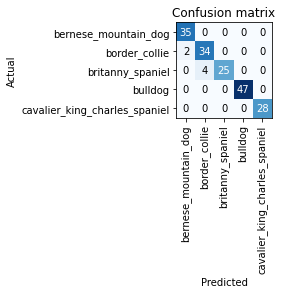

In [66]:
interp = ClassificationInterpretation.from_learner(learner)
interp.plot_confusion_matrix()

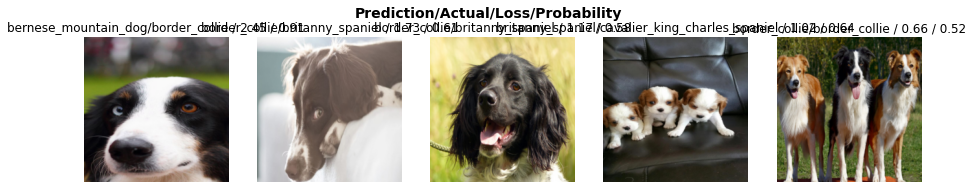

In [64]:
interp.plot_top_losses(5, nrows=1)

In [61]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [63]:
img = PILImage.create(btn_upload.data[0])
learner.predict(img)

('border_collie',
 tensor(1),
 tensor([4.4231e-09, 1.0000e+00, 4.3741e-09, 1.5118e-08, 1.2434e-08]))

In [56]:
learn.export('dogbreedclassifier.pkl')

In [59]:
!mv dogbreedclassifier.pkl drive/MyDrive/MyMLProjects/Chapter2/dogs